2023-1-60-075

In [ ]:
import cv2
import numpy as np

# # Load the image
img = cv2.imread('/content/Picture1.png', 0) # Load in grayscale

# # Apply Fourier Transform
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

# # Shift the zero-frequency component to the center
dft_shift = np.fft.fftshift(dft)

# # Calculate the magnitude spectrum (for visualization)
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))


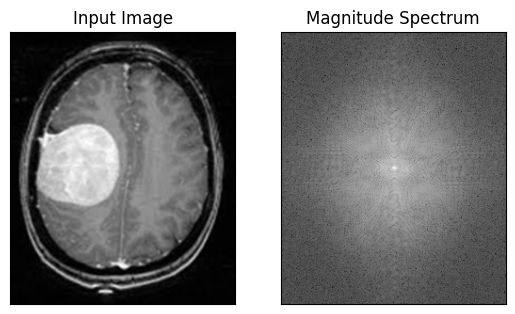

In [ ]:
import matplotlib.pyplot as plt

# Visualize the magnitude spectrum
plt.subplot(121), plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
import cv2
import numpy as np


dft_ishift = np.fft.ifftshift(dft_shift)

# # Apply Inverse Fourier Transform
img_back = cv2.idft(dft_ishift)

# # Calculate the magnitude
img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])


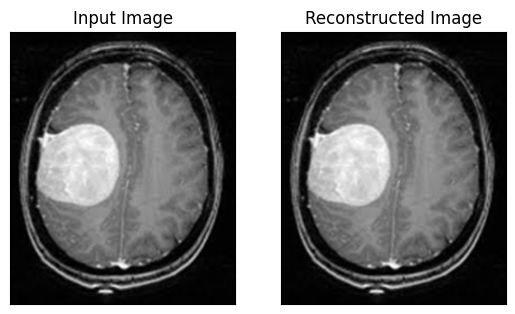

In [ ]:
# Visualize the reconstructed image

plt.subplot(121), plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_back, cmap = 'gray')
plt.title('Reconstructed Image')
plt.xticks([]), plt.yticks([])
plt.show()

# Task
Implement and visualize image compression using DCT, Haar, and a combination of DCT and Haar transforms.

In [ ]:
img_gray = cv2.imread('/content/Picture4.png', cv2.IMREAD_GRAYSCALE)

In [ ]:
from scipy.fftpack import dct, idct

# Perform 2D DCT
dct_img = dct(dct(img_gray.T, norm='ortho').T, norm='ortho')

# Apply simple quantization
quantization_factor = 10
quantized_dct_img = np.round(dct_img / quantization_factor) * quantization_factor

# Perform 2D Inverse DCT
img_dct_compressed = idct(idct(quantized_dct_img.T, norm='ortho').T, norm='ortho')

# Ensure the output is in a suitable format for visualization (e.g., uint8)
img_dct_compressed = np.uint8(np.clip(img_dct_compressed, 0, 255))

In [ ]:
import pywt

# Perform 2D Haar Wavelet Transform
coeffs2 = pywt.dwt2(img_gray, 'haar')
cA, (cH, cV, cD) = coeffs2

# Implement a simple compression strategy (thresholding)
threshold = 20
cA[np.abs(cA) < threshold] = 0
cH[np.abs(cH) < threshold] = 0
cV[np.abs(cV) < threshold] = 0
cD[np.abs(cD) < threshold] = 0

# Reconstruct the image using Inverse Haar Wavelet Transform
img_haar_compressed = pywt.idwt2((cA, (cH, cV, cD)), 'haar')

# Ensure the reconstructed image is in a suitable format (uint8)
img_haar_compressed = np.uint8(np.clip(img_haar_compressed, 0, 255))

In [ ]:
# Apply Haar wavelet transform
coeffs2_haar = pywt.dwt2(img_gray, 'haar')
cA_haar, (cH_haar, cV_haar, cD_haar) = coeffs2_haar

# Apply 2D DCT to the approximation coefficients
dct_cA_haar = dct(dct(cA_haar.T, norm='ortho').T, norm='ortho')

# Apply quantization to the DCT coefficients of approximation subband
quantized_dct_cA_haar = np.round(dct_cA_haar / quantization_factor) * quantization_factor

# Apply inverse 2D DCT to the compressed approximation coefficients
idct_cA_haar = idct(idct(quantized_dct_cA_haar.T, norm='ortho').T, norm='ortho')

# Reconstruct the image using inverse Haar wavelet transform
img_dct_haar_compressed = pywt.idwt2((idct_cA_haar, (cH_haar, cV_haar, cD_haar)), 'haar')

# Ensure the reconstructed image is in a suitable format (uint8)
img_dct_haar_compressed = np.uint8(np.clip(img_dct_haar_compressed, 0, 255))

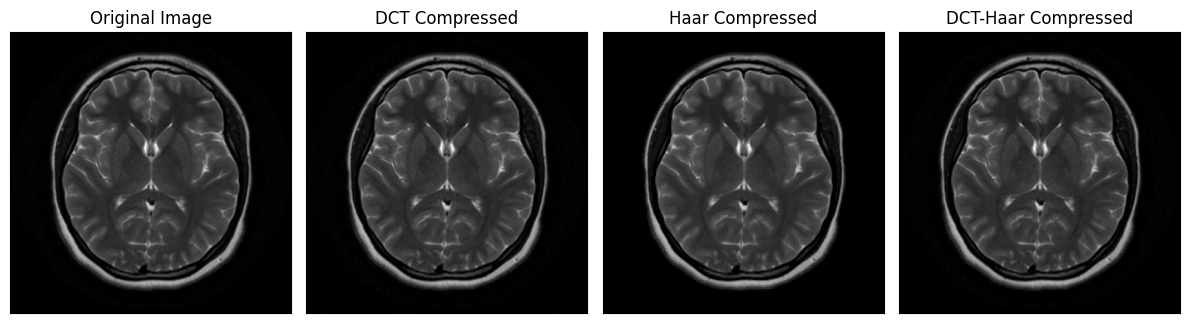

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(141), plt.imshow(img_gray, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(142), plt.imshow(img_dct_compressed, cmap='gray')
plt.title('DCT Compressed'), plt.xticks([]), plt.yticks([])

plt.subplot(143), plt.imshow(img_haar_compressed, cmap='gray')
plt.title('Haar Compressed'), plt.xticks([]), plt.yticks([])

plt.subplot(144), plt.imshow(img_dct_haar_compressed, cmap='gray')
plt.title('DCT-Haar Compressed'), plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()

In [ ]:
import math

def calculate_psnr(original_img, compressed_img):
    """Calculates the Peak Signal-to-Noise Ratio (PSNR) between two images."""
    mse = np.mean((original_img - compressed_img) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

def calculate_compression_ratio(original_img, compressed_representation):
    """Calculates the compression ratio based on non-zero coefficients."""
    original_size = original_img.size
    if isinstance(compressed_representation, tuple):
        # For Haar and DCT-Haar, count non-zero elements in all coefficient arrays
        compressed_size = sum(np.count_nonzero(coeff) for sublist in compressed_representation for coeff in (sublist if isinstance(sublist, tuple) else [sublist]))
    else:
        # For DCT, count non-zero elements in the single coefficient matrix
        compressed_size = np.count_nonzero(compressed_representation)

    if compressed_size == 0:
        return float('inf') # Avoid division by zero if all coefficients are zero
    return original_size / compressed_size

# Calculate PSNR for each method
psnr_dct = calculate_psnr(img_gray, img_dct_compressed)
psnr_haar = calculate_psnr(img_gray, img_haar_compressed)
psnr_dct_haar = calculate_psnr(img_gray, img_dct_haar_compressed)

# Calculate Compression Ratio for each method
# For DCT, use quantized_dct_img
compression_ratio_dct = calculate_compression_ratio(img_gray, quantized_dct_img)

# For Haar, use the thresholded coefficients (cA, cH, cV, cD)
# Need to get the thresholded coeffs again as they were modified in the previous step
coeffs2_haar_thresholded = pywt.dwt2(img_gray, 'haar')
cA_thresh, (cH_thresh, cV_thresh, cD_thresh) = coeffs2_haar_thresholded
cA_thresh[np.abs(cA_thresh) < threshold] = 0
cH_thresh[np.abs(cH_thresh) < threshold] = 0
cV_thresh[np.abs(cV_thresh) < threshold] = 0
cD_thresh[np.abs(cD_thresh) < threshold] = 0
compression_ratio_haar = calculate_compression_ratio(img_gray, (cA_thresh, (cH_thresh, cV_thresh, cD_thresh)))


# For DCT-Haar, use quantized_dct_cA_haar and the other Haar coefficients (cH_haar, cV_haar, cD_haar)
compression_ratio_dct_haar = calculate_compression_ratio(img_gray, (quantized_dct_cA_haar, (cH_haar, cV_haar, cD_haar)))


# Print the results
print(f"DCT Compression:")
print(f"  PSNR: {psnr_dct:.2f} dB")
print(f"  Compression Ratio: {compression_ratio_dct:.2f}")
print("-" * 20)

print(f"Haar Compression:")
print(f"  PSNR: {psnr_haar:.2f} dB")
print(f"  Compression Ratio: {compression_ratio_haar:.2f}")
print("-" * 20)

print(f"DCT-Haar Compression:")
print(f"  PSNR: {psnr_dct_haar:.2f} dB")
print(f"  Compression Ratio: {compression_ratio_dct_haar:.2f}")

DCT Compression:
  PSNR: 43.62 dB
  Compression Ratio: 5.35
--------------------
Haar Compression:
  PSNR: 37.90 dB
  Compression Ratio: 7.31
--------------------
DCT-Haar Compression:
  PSNR: 45.63 dB
  Compression Ratio: 1.60



 Summary

 Data Analysis

* The image was loaded in grayscale mode without issues.
* Image compression was carried out using three techniques: DCT, Haar, and a hybrid DCT–Haar method.
* In the DCT approach, a quantization factor of 10 was applied to the DCT coefficients.
* In the Haar method, a threshold value of 20 was applied to the wavelet coefficients.
* For the DCT–Haar method, the Haar transform was first applied, and DCT with quantization was performed on the approximation coefficients, while the detail coefficients remained unchanged.
* The compressed images were reconstructed using the corresponding inverse transforms.
* Comparative visualizations were created showing the original image alongside the compressed outputs from each technique.
* Quantitative metrics—PSNR and compression ratio—were computed for each method:

  * **DCT:** PSNR = 43.62 dB, Compression Ratio = 5.35
  * **Haar:** PSNR = 37.90 dB, Compression Ratio = 7.31
  * **DCT–Haar:** PSNR = 45.63 dB, Compression Ratio = 1.60







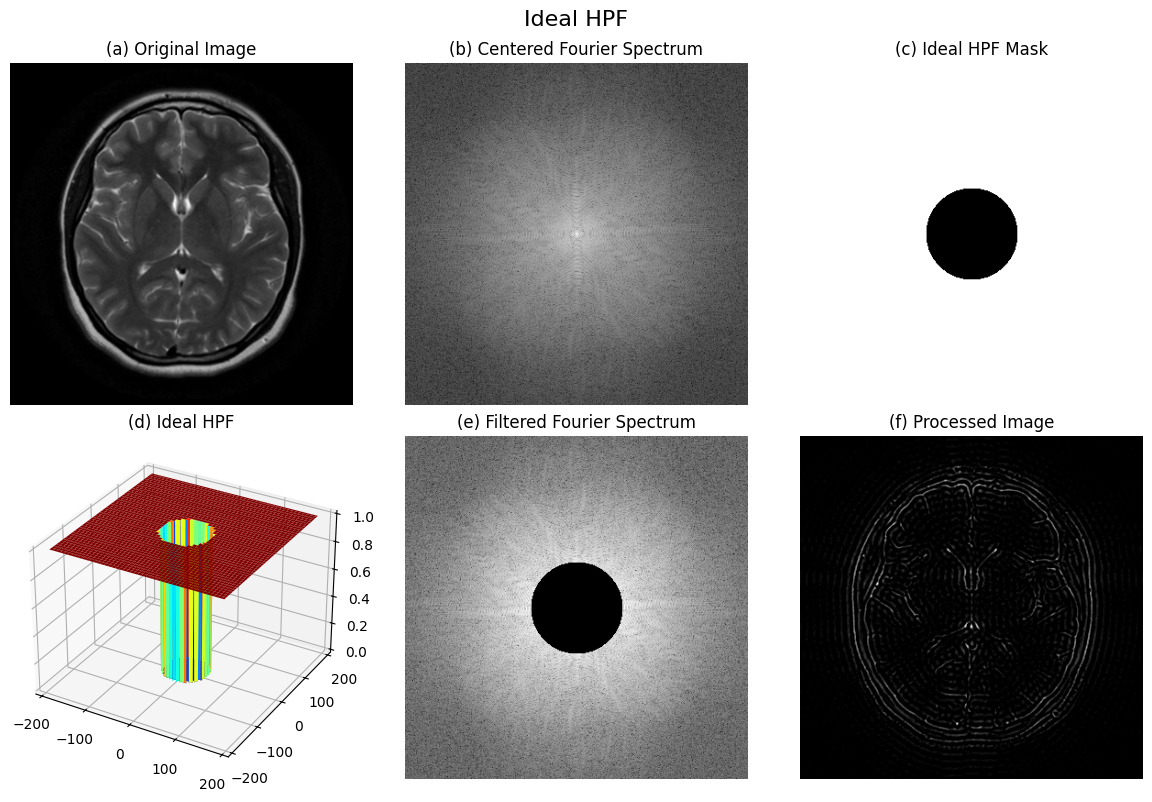

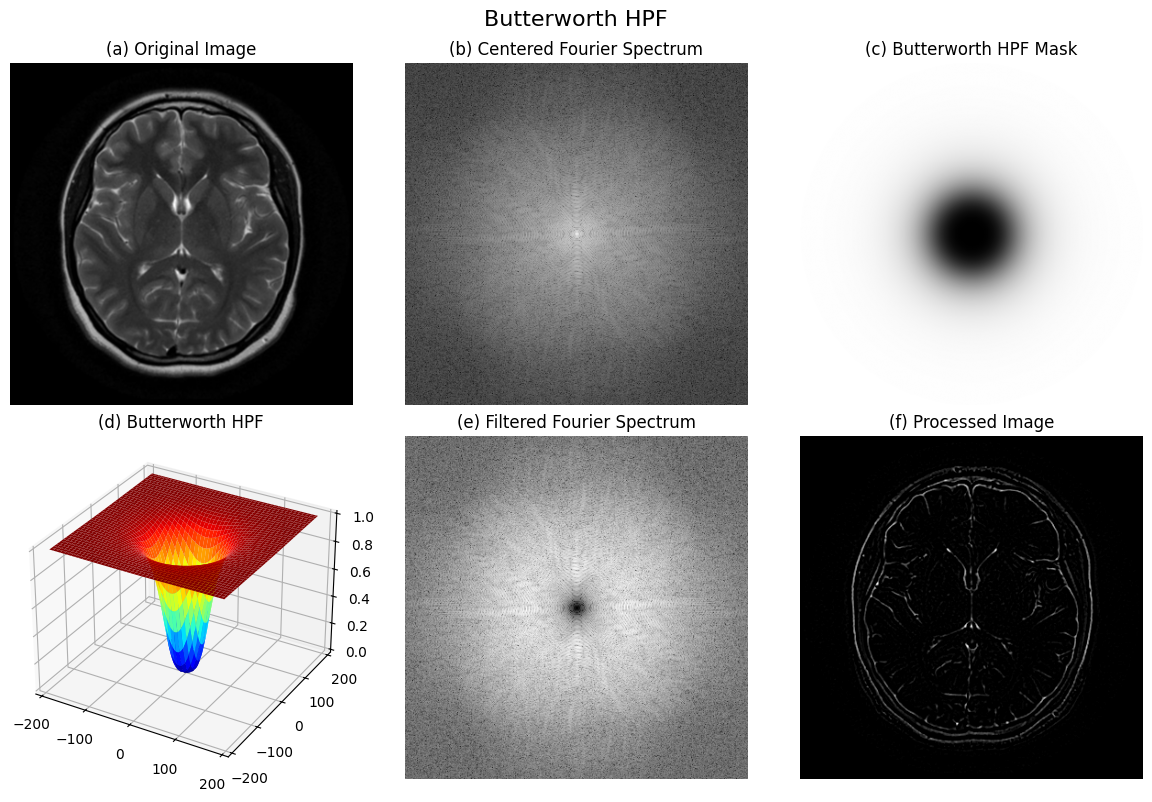

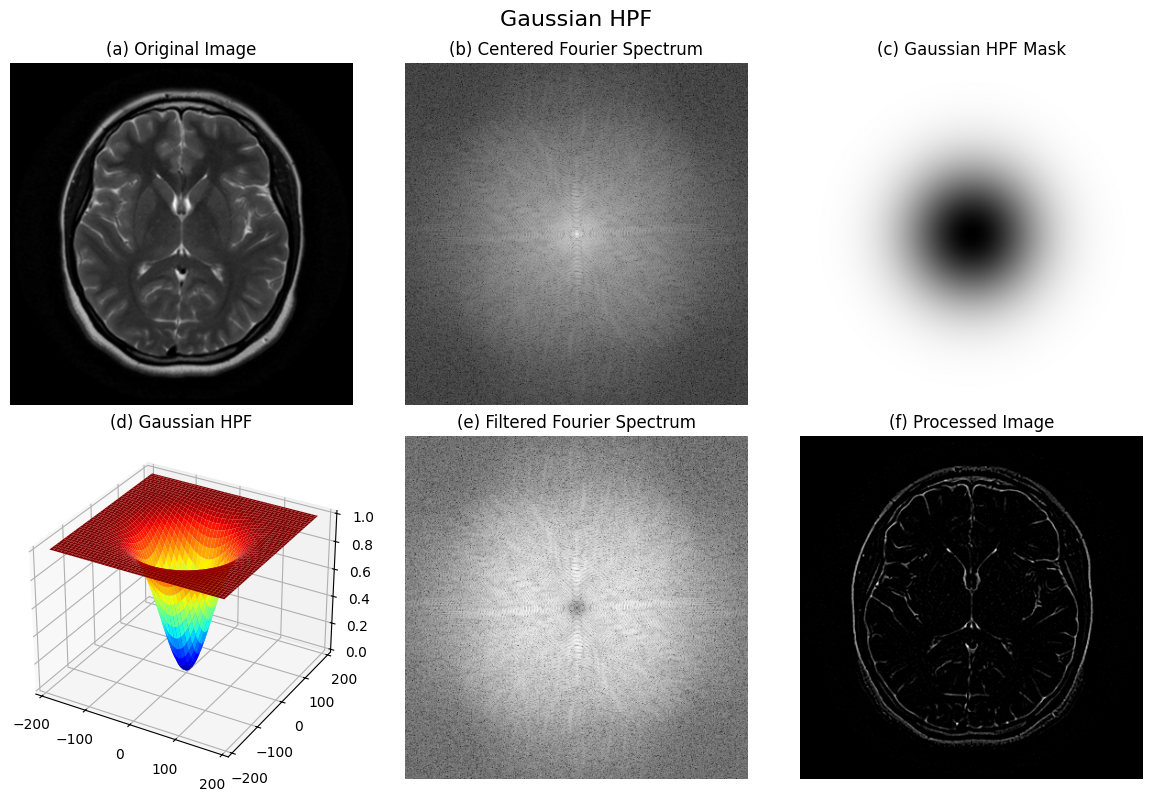

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Read Image
img = cv2.imread('/content/Picture4.png')
if img is None:
    raise FileNotFoundError("Image not found!")

# Convert to grayscale if RGB
if len(img.shape) == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

M, N = img.shape
F = np.fft.fftshift(np.fft.fft2(img))

# High-Pass Filter Parameters
D0 = 50  # Cutoff frequency
n = 2    # Order for Butterworth filter
U, V = np.meshgrid(np.arange(-N//2, N//2), np.arange(-M//2, M//2))
D = np.sqrt(U**2 + V**2)

# Create High-Pass Filters
IHPF = np.double(D >= D0)  # Ideal HPF
BHPF = 1 / (1 + (D0 / (D + 1e-5))**(2 * n))  # Butterworth HPF
GHPF = 1 - np.exp(-(D**2) / (2 * (D0**2)))   # Gaussian HPF

filters = [IHPF, BHPF, GHPF]
titles = ['Ideal HPF', 'Butterworth HPF', 'Gaussian HPF']

# Loop through filters
for k in range(3):
    H = filters[k]

    # Apply filter in frequency domain
    F_filtered = F * H

    # Inverse Fourier Transform
    img_filtered = np.real(np.fft.ifft2(np.fft.ifftshift(F_filtered)))

    # Plot results
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle(titles[k], fontsize=16)

    # (a) Original Image
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(img, cmap='gray')
    ax1.set_title('(a) Original Image')
    ax1.axis('off')

    # (b) Centered Fourier Spectrum
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.imshow(np.log(1 + np.abs(F)), cmap='gray')
    ax2.set_title('(b) Centered Fourier Spectrum')
    ax2.axis('off')

    # (c) High-Pass Filter Mask
    ax3 = fig.add_subplot(2, 3, 3)
    ax3.imshow(H, cmap='gray')
    ax3.set_title(f'(c) {titles[k]} Mask')
    ax3.axis('off')

    # (d) 3D Surface Plot
    ax4 = fig.add_subplot(2, 3, 4, projection='3d')
    X, Y = np.meshgrid(np.arange(-N//2, N//2), np.arange(-M//2, M//2))
    ax4.plot_surface(X, Y, H, cmap='jet')
    ax4.set_title(f'(d) {titles[k]}')

    # (e) Filtered Fourier Spectrum
    ax5 = fig.add_subplot(2, 3, 5)
    ax5.imshow(np.log(1 + np.abs(F_filtered)), cmap='gray')
    ax5.set_title('(e) Filtered Fourier Spectrum')
    ax5.axis('off')

    # (f) Processed Image
    ax6 = fig.add_subplot(2, 3, 6)
    ax6.imshow(np.uint8(np.clip(img_filtered, 0, 255)), cmap='gray')
    ax6.set_title('(f) Processed Image')
    ax6.axis('off')

    plt.tight_layout()
    plt.show()


Conclusion: Among the three high pass filters, Gaussian High Pass Filter (GHPF) produces the better enhanced image (sharpen) for the given image.

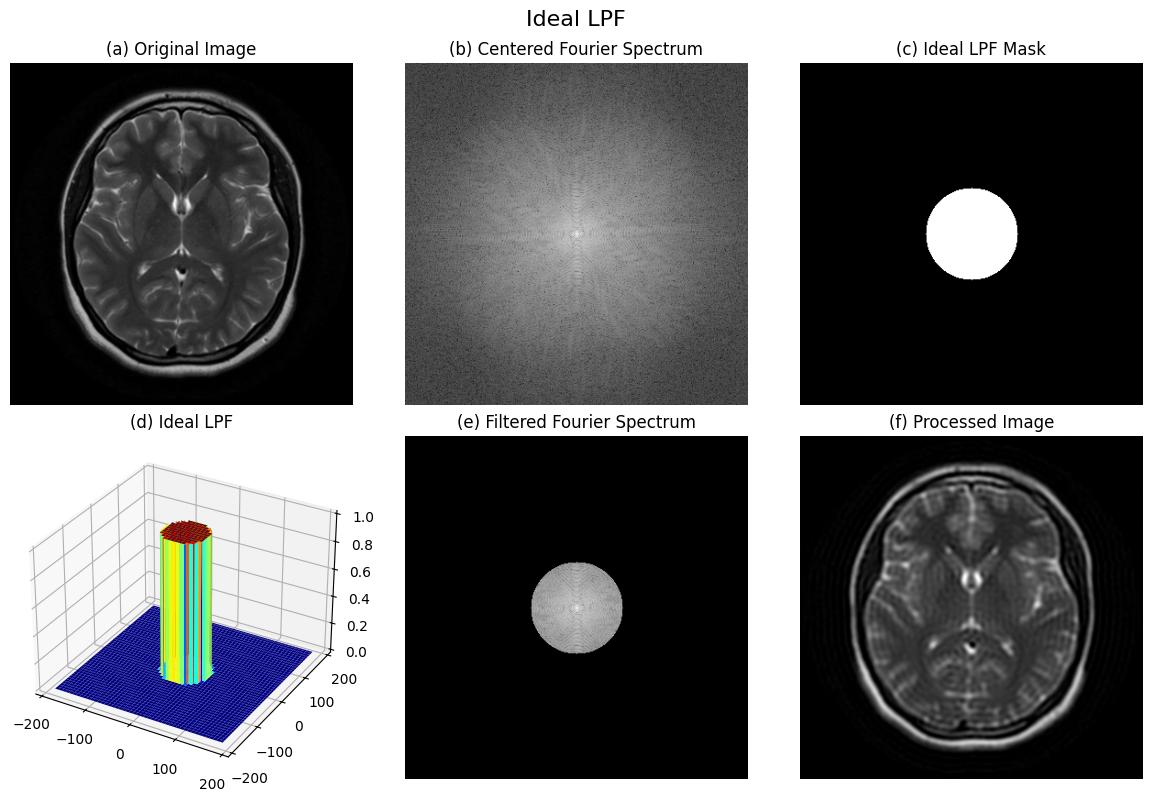

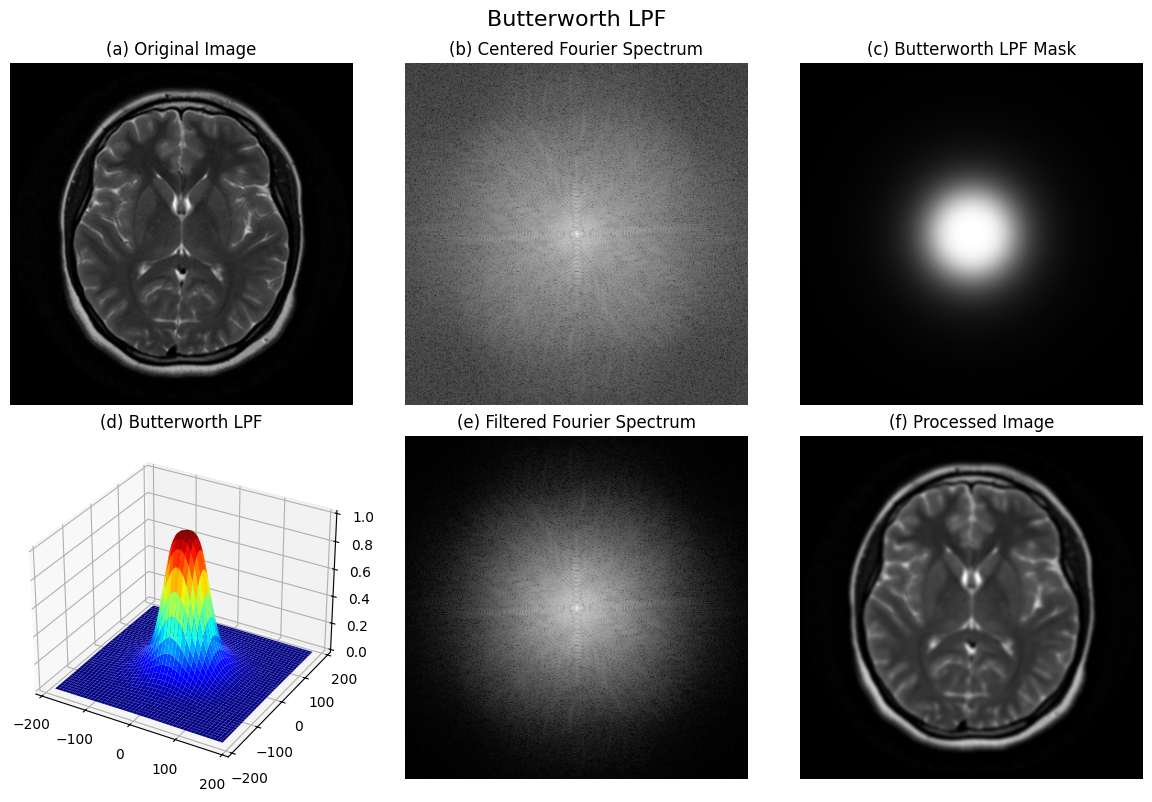

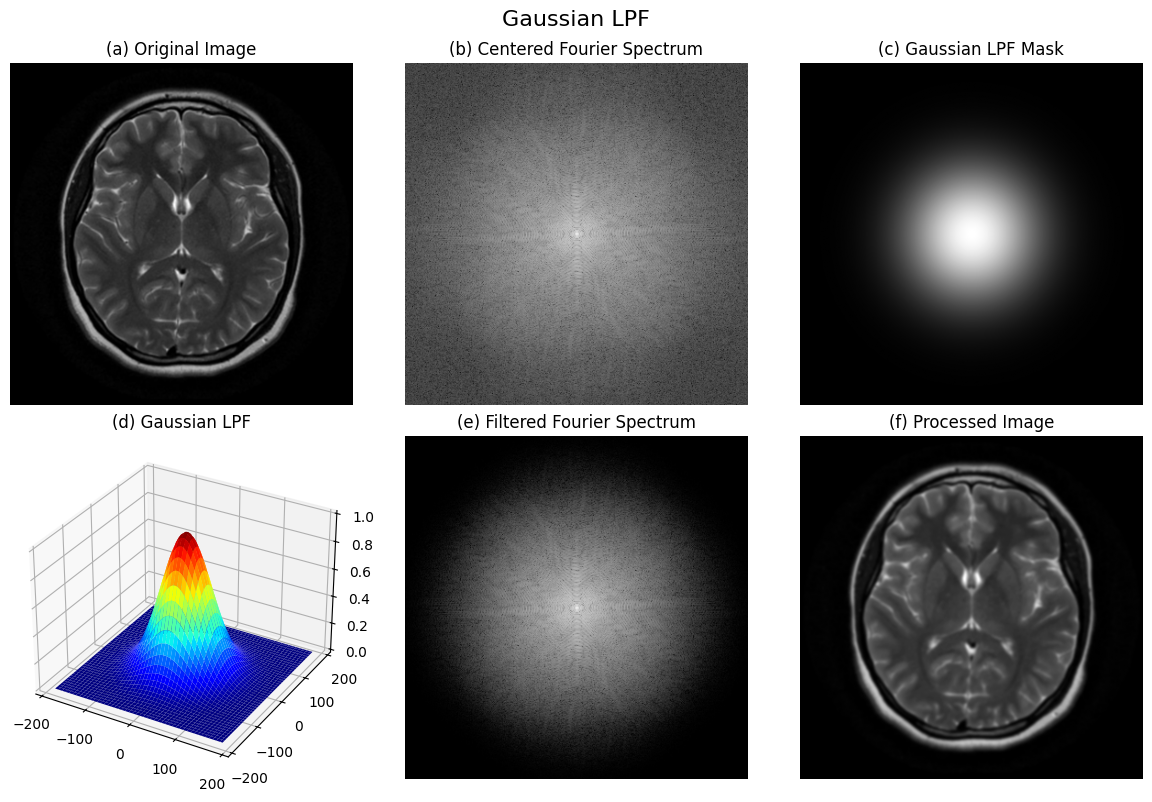

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting

# Read Image
img = cv2.imread('/content/Picture4.png')
if img is None:
    raise FileNotFoundError("Image not found!")

# Convert to grayscale if RGB
if len(img.shape) == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

M, N = img.shape
F = np.fft.fftshift(np.fft.fft2(img))

# Low-Pass Filter Parameters
D0 = 50  # Cutoff frequency
n = 2    # Order for Butterworth filter
U, V = np.meshgrid(np.arange(-N//2, N//2), np.arange(-M//2, M//2))
D = np.sqrt(U**2 + V**2)

# Create Low-Pass Filters
ILPF = np.double(D <= D0)                           # Ideal LPF
BLPF = 1 / (1 + (D / (D0 + 1e-5))**(2 * n))         # Butterworth LPF
GLPF = np.exp(-(D**2) / (2 * (D0**2)))              # Gaussian LPF

filters = [ILPF, BLPF, GLPF]
titles = ['Ideal LPF', 'Butterworth LPF', 'Gaussian LPF']

# Loop through filters
for k in range(3):
    H = filters[k]

    # Apply filter in frequency domain
    F_filtered = F * H

    # Inverse Fourier Transform
    img_filtered = np.real(np.fft.ifft2(np.fft.ifftshift(F_filtered)))

    # Plot results
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle(titles[k], fontsize=16)

    # (a) Original Image
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(img, cmap='gray')
    ax1.set_title('(a) Original Image')
    ax1.axis('off')

    # (b) Centered Fourier Spectrum
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.imshow(np.log(1 + np.abs(F)), cmap='gray')
    ax2.set_title('(b) Centered Fourier Spectrum')
    ax2.axis('off')

    # (c) Low-Pass Filter Mask
    ax3 = fig.add_subplot(2, 3, 3)
    ax3.imshow(H, cmap='gray')
    ax3.set_title(f'(c) {titles[k]} Mask')
    ax3.axis('off')

    # (d) 3D Surface Plot of Filter
    ax4 = fig.add_subplot(2, 3, 4, projection='3d')
    X, Y = np.meshgrid(np.arange(-N//2, N//2), np.arange(-M//2, M//2))
    ax4.plot_surface(X, Y, H, cmap='jet')
    ax4.set_title(f'(d) {titles[k]}')

    # (e) Filtered Fourier Spectrum
    ax5 = fig.add_subplot(2, 3, 5)
    ax5.imshow(np.log(1 + np.abs(F_filtered)), cmap='gray')
    ax5.set_title('(e) Filtered Fourier Spectrum')
    ax5.axis('off')

    # (f) Processed Image
    ax6 = fig.add_subplot(2, 3, 6)
    ax6.imshow(np.uint8(np.clip(img_filtered, 0, 255)), cmap='gray')
    ax6.set_title('(f) Processed Image')
    ax6.axis('off')

    plt.tight_layout()
    plt.show()
